# Introducing Ray

For many tasks in machine learning and data engineering, it's nice to have an option for multiprocessing.  There are several solutions, from workload-oriented solutions like Argo to data flow solutions like Spark, or AWS Batch.

But my go-to for this sort of thing is Ray (http://ray.io).  It offers a number of desiderata:

1. Can be self-hosted on many cloud providers
2. Can be managed if desired (Anyscale)
3. Can abstract away cluster and workstation management from DevOps tools 
4. Can auto-shutdown clusters and workspaces if idle (don't underestimate this)
5. Supports "jobs" for submission (brings up a cluster, runs a job, shuts down the cluster)
6. Supports local development! (don't underestimate this either)

For this notebook, we'll be running ray in local mode, treating our laptop as its own tiny one-node cluster.                                                      

In [ ]:
import ray
# initialize the ray engine.  You do this once, and it can be done in a separate window.
# there are a lot of things that can go wrong if you're not disciplined about this, but
# there's a lot of power too--you can join an ad hoc network, you can create a long running
# cluster... but for now, let's just call it directly.  If you add "address=auto" you can connect
# to a running ray instance--or to another remote cluster and join it!
ray.init(include_dashboard=True, ignore_reinit_error=True)

# NOTE
Fun fact: Ray allows you to connect computers to form an ad hoc cluster if one computer initializes itself as the head node (from the command line you can use
```
ray start --head --port 6379
```

and then attach other nodes to the cluster by running this on each node:
```
ray start --address='<head_node_ip>:6379'
```

...although I didn't want to go that route today because I wasn't sure the nodes would be exposed on eduroam and people have enough to worry about without their buddies executing arbitrary code on their machines.  Feel free to try this with a trusted friend!

The most basic thing Ray allows you to do is define a function as "remote"; calling a remote function returns back a future, and you can collect the results of those futures.  In this sense it doesn't seem much different from something like joblib or the various multiprocessing tools available in standard Python.

But Ray offers quite a bit more, because it handles a lot of background serialization that you would otherwise have to get involved with, and it allows you to specify the resources needed by each of your remote routines, which helps with scheduling on both homogenous and heterogenous clusters.

Even more importantly, Ray has a number of other libraries built on top of this for training and tuning machine learning models using distributed data parallel strategies, distributed models, running reinforcement learning experiments, and more.  Those could each be their own workshops, but Ray Data will be the focus of this one.

First off, let's look at an extremely simple remote call, with an artificial delay to simulate that it takes a lot of computation.

In [ ]:
import time

# let's make a simple little profiler
class Print_time:
    def __enter__(self):
        self.start = time.perf_counter()
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.end = time.perf_counter()
        self.elapsed = self.end - self.start
        print(f"Time taken: {self.elapsed:.4f} seconds")

def square(x: int)->int:
    time.sleep(1)
    return x*x

numbers = range(10)
with Print_time():
    squares = [square(x) for x in numbers]
    print(squares)

As one would expect, if each task takes about a second, 10 tasks done serially takes 10 seconds; no great surprise.

We can decorate a function to make it run remotely, however, and that allows the tasks to be done in parallel:

In [ ]:
#you could get a similar result by saying square_task=ray.remote(square)
@ray.remote
def square_task(x: int)->int:
    return square(x)

with Print_time():
    futures = [square_task.remote(x) for x in numbers]
    squares = ray.get(futures)
    print(squares)

What's happened in the above is that Ray has, as one would expect, defined an individual task for each of the squaring operations and sent them off as individual processes, serializing the numbers on the way and serializing the results on the way back.  From the perspective of the python program, this looks extremely simplistic, but there's a fair amount taking place under the hood, particularly since the executing code has no idea where the computation was performed--it could be on the laptop, but it also could be off in another node somewhere in the cloud provided that that node is connected to this cluster.

Now that you've run a task, it's worth looking at the local dashboard, which is probably accessible at http://localhost:8265, and should present you with a number of options such as the jobs widget:

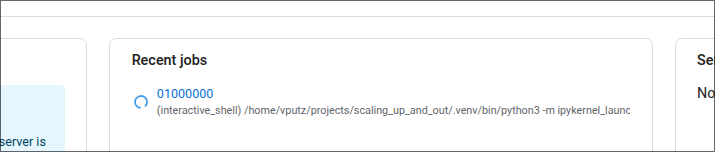

The jobs widget for an interactive notebook is always running, so don't worry that it still has a progress ring.  Expand the job to see the individual tasks:

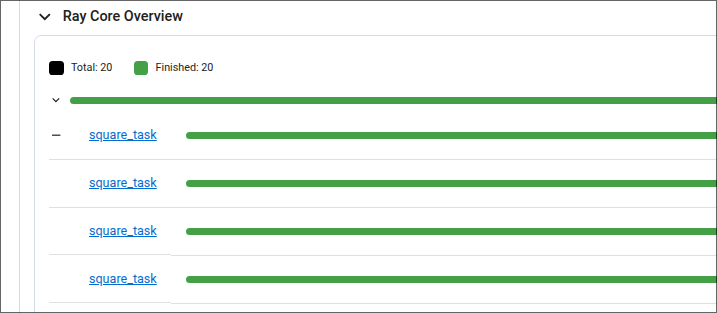

The dashboard is your friend.  The logging can be a bit confusing, but particularly when running nested tasks, being able to see the progress and results is very handy.  Unfortunately some metrics aren't available in a local self-hosted cluster, but it's still nice.

Speaking of nested tasks, let's try a simple one.

In [ ]:
@ray.remote
def sum_of_squares_task(xs: list[int])->int:
    squares = ray.get([square_task.remote(x) for x in numbers])
    return sum(squares)

with Print_time():
    sum_of_squares = ray.get(sum_of_squares_task.remote(numbers))
    print(sum_of_squares)

Now look at the dashboard and expand the resulting sum_of_squares job to see the nested square tasks underneath it:

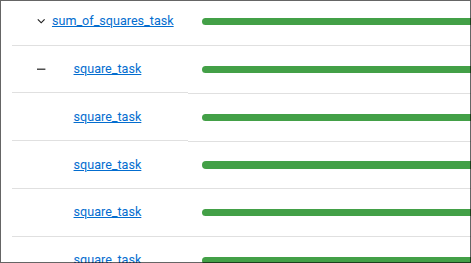

Excellent: simple syntax, flexible results.  Let's take a look at data processing built on top of this.